data is read from https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/stackoverflow.csv

original data source : https://www.kaggle.com/stackoverflow/stacksample?select=Answers.csv

1. importing the libraries

In [ ]:
!pip install scikit-multilearn

import numpy as np
import pandas as pd

import ast

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

     |████████████████████████████████| 89 kB 3.8 MB/s 


In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import LabelPowerset

from sklearn.metrics import hamming_loss, jaccard_score, f1_score

In [ ]:
!pip install skmultilearn

ERROR: Could not find a version that satisfies the requirement skmultilearn (from versions: none)
ERROR: No matching distribution found for skmultilearn


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

2. Read data

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/stackoverflow.csv')
# data = pd.read_csv('https://www.kaggle.com/stackoverflow/stacksample?select=Answers.csv')

In [ ]:
data.rename(columns = {'Unnamed: 0':'Initial ID'}, inplace = True)

In [ ]:
# data.head(10)
data

,Initial ID,Text,Tags
0,2,aspnet site maps has anyone got experience cre...,"['sql', 'asp.net']"
1,4,adding scripting functionality to net applicat...,"['c#', '.net']"
2,5,should i use nested classes in this case i am ...,['c++']
3,6,homegrown consumption of web services i have b...,['.net']
4,8,automatically update version number i would li...,['c#']
...,...,...,...
48971,1262668,using lambda in default initializer gcc vs cla...,['c++']
48972,1262834,stl list very bad performance it is supposed t...,['c++']
48973,1262915,how to use a dict to subset a dataframe say i ...,['python']
48974,1263065,is there a way to use itertools in python to c...,['python']


In [ ]:
print('Shape of the dataset : ', data.shape)

Shape of the dataset :  (48976, 3)


In [ ]:
data.dtypes

Initial ID     int64
Text          object
Tags          object
dtype: object

3. Data Preprocessing : **bold text**

count number of tags in a question and frequency of  each tag:

In [ ]:
data['tag_count'] = data['Tags'].apply(lambda x : len(x.split()))
data

,Initial ID,Text,Tags,tag_count
0,2,aspnet site maps has anyone got experience cre...,"['sql', 'asp.net']",2
1,4,adding scripting functionality to net applicat...,"['c#', '.net']",2
2,5,should i use nested classes in this case i am ...,['c++'],1
3,6,homegrown consumption of web services i have b...,['.net'],1
4,8,automatically update version number i would li...,['c#'],1
...,...,...,...,...
48971,1262668,using lambda in default initializer gcc vs cla...,['c++'],1
48972,1262834,stl list very bad performance it is supposed t...,['c++'],1
48973,1262915,how to use a dict to subset a dataframe say i ...,['python'],1
48974,1263065,is there a way to use itertools in python to c...,['python'],1


In [ ]:
data.dtypes

Initial ID     int64
Text          object
Tags          object
tag_count      int64
dtype: object

In [ ]:
# print(data['Tags'].iloc[0].dtype)
print(type(data['Tags'].iloc[0]))

<class 'str'>


converting each tag in data['Tags'] from string to list of strings

In [ ]:
# def stringToList(s):
#     # listRes = list(string.split(","))
#     listRes = s.split(",")
#     return listRes

# https://appdividend.com/2019/11/12/how-to-convert-python-string-to-list-example/

In [ ]:
data['Tags'] = data['Tags'].apply(lambda x : ast.literal_eval(x))
print(type(data['Tags'].iloc[0]))
"""when converting to other type from string 
its better to use eval() with abstract syntax tree(ast)
"""

<class 'list'>


'when converting to other type from string \nits better to use eval() with abstract syntax tree(ast)\n'

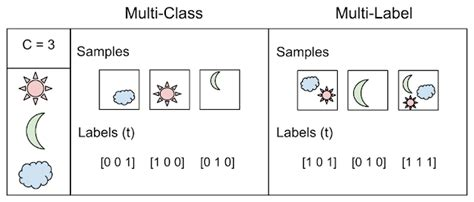

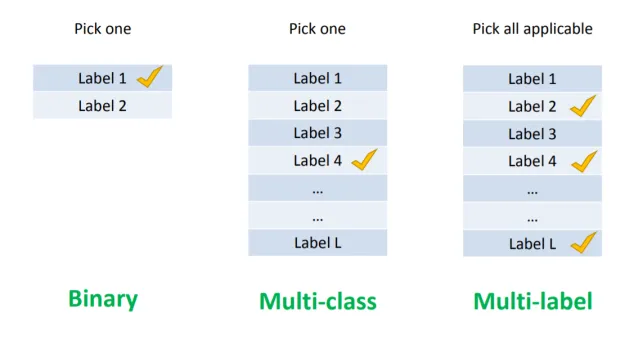

In a multi class classification, output can take one value form  a set of values at a time.

In a multi label classification, output can have multiple values at a time. 

In [ ]:
data.dtypes

Initial ID     int64
Text          object
Tags          object
tag_count      int64
dtype: object

In [ ]:
y = data['Tags']
y
type(y[0])

list

examples of multi label binarizer :

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html

https://www.programcreek.com/python/example/85906/sklearn.preprocessing.MultiLabelBinarizer


4. basic data analysis on Tag

In [ ]:
print(data['tag_count'].value_counts())

1    38751
2     8963
3     1099
4      160
5        3
Name: tag_count, dtype: int64


In [ ]:
print( "Maximum number of tags in a question: ", data['tag_count'].max())
print( "Minimum number of tags in a question: ", data['tag_count'].min())
print( "Average number of tags in a question: ", round(data['tag_count'].mean(), 3))

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  1.238


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Frequency (log scaled)')

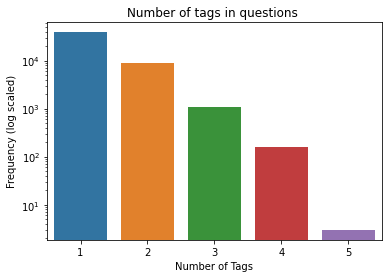

In [ ]:
# fig = plt.gcf()
# fig.set_size_inches( 10, 8)
fig = sns.countplot(data['tag_count'])
plt.yscale('log')
plt.title("Number of tags in questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency (log scaled)")

convert to multi label binarizer

In [ ]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['Tags'])

In [ ]:
y

array([[0, 0, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
mlb.classes_

array(['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'css', 'html',
       'ios', 'iphone', 'java', 'javascript', 'jquery', 'mysql',
       'objective-c', 'php', 'python', 'ruby', 'ruby-on-rails', 'sql'],
      dtype=object)

making another dataframe with y and labels as features/columns

In [ ]:
tagMatrix = pd.DataFrame(y, columns = mlb.classes_)
# tagMatrix
tagMatrix.shape

(48976, 20)

In [ ]:
count1 = 0;
for val in tagMatrix['sql'] :
    if(val == 1) : count1+=1;
print(count1)

count = tagMatrix['sql'].sum()
print(count)

1389
1389


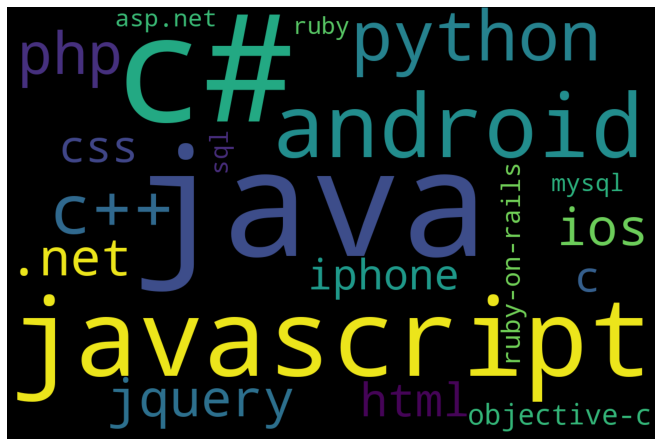

In [ ]:
tag_freq_table = {}
for tag in tagMatrix.columns:
    # print(tag)
    tag_freq_table[tag] = tagMatrix[tag].sum()

# tag_freq_table
word_cloud = WordCloud(width=1200,height=800,).generate_from_frequencies(tag_freq_table)
plt.figure(figsize = (10,6))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

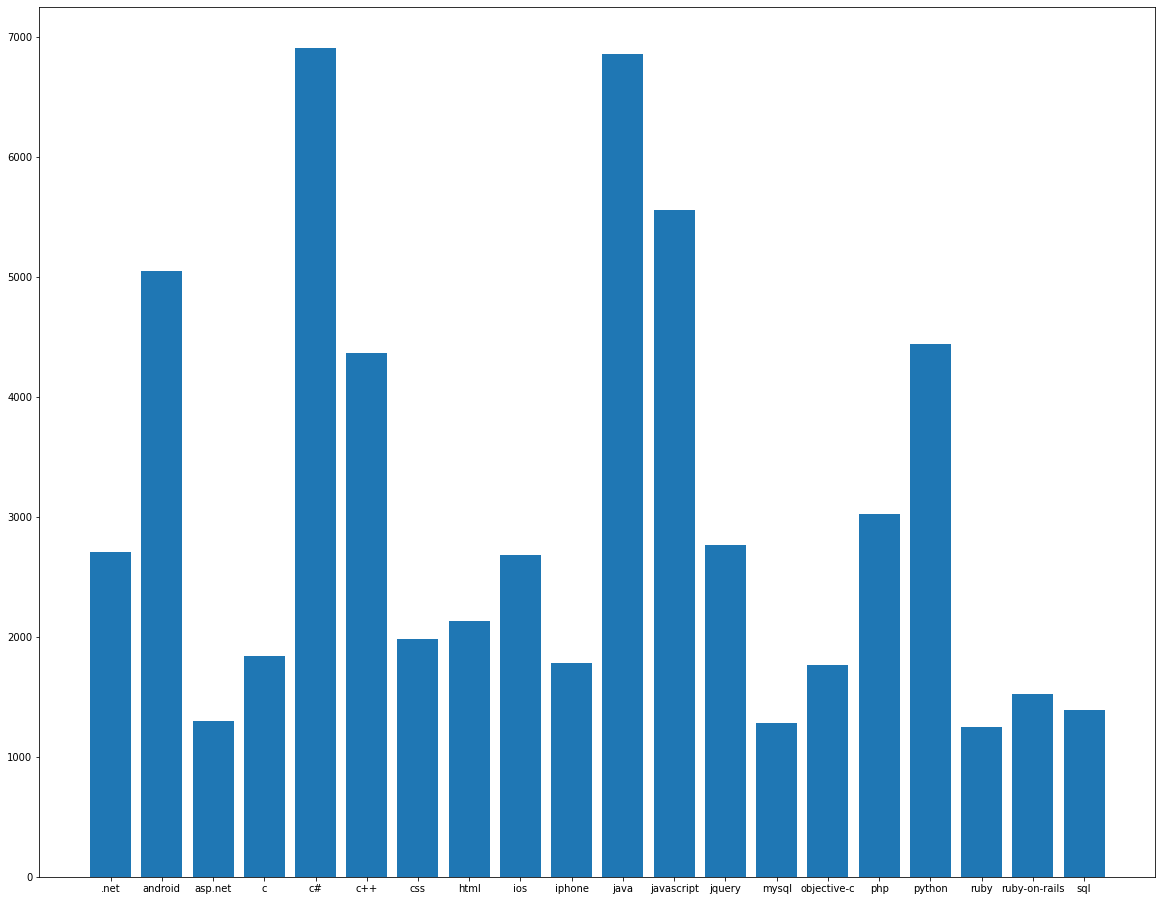

In [ ]:
names = list(tag_freq_table.keys())
values = list(tag_freq_table.values())

plt.figure(figsize = (20,16))
plt.bar(range(len(tag_freq_table)),values,tick_label=names)
plt.show()


In [ ]:
# #Bar plot of top 20 tags
# tagMatrix.sort().head(20).plot(kind='bar')
# plt.title('Frequency of top 20 tags')
# plt.xticks(i, tag_df_sorted['Tags'])
# plt.xlabel('Tags')
# plt.ylabel('Counts')
# plt.show()

In [ ]:
tfidf = TfidfVectorizer(analyzer='word', max_features=1000, ngram_range=(1,3), stop_words='english')
X = tfidf.fit_transform(data['Text'])
X
# https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/

<48976x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1239765 stored elements in Compressed Sparse Row format>



*   Term Frequency (TF):

        Term frequency (TF) often used in Text Mining, NLP and Information Retrieval tells you how frequently a term occurs in a document. In the context natural language, terms correspond to words or phrases. Since every document is different in length, it is possible that a term would appear more often in longer documents than shorter ones. Thus, term frequency is often divided by the  the total number of terms in the document as a way of normalization.

        TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).


*   IDF: 
        Inverse Document Frequency, which    measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

        IDF(t) = log_e(Total number of documents / Number of documents with term t in it). 


Example:

Consider a document containing 100 words wherein the word cat appears 3 times. The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.


source : 
http://tfidf.com/


In [ ]:
# tfidf.vocabulary_
X.shape, y.shape

((48976, 1000), (48976, 20))

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size = 0.2, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size = 0.2)
y_train

array([[1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

multilabel classification metrices :

https://en.wikipedia.org/wiki/Multi-label_classification

https://scikit-learn.org/stable/modules/multiclass.html#multilabel-classification

Jaccard Similarity :

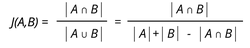



In [ ]:
def j_score(y_true, y_pred) :
    J = np.minimum(y_true, y_pred).sum(axis=1)/np.maximum(y_true, y_pred).sum(axis=1)
    return J.mean()*100

def print_score(y_pred, clf) :
    Jaccard_score = j_score(y_test, y_pred)
    print('\n--------------------------------------') 
    print("classifier : ", clf.__class__.__name__)
    print('Jaccard Score {}'.format(Jaccard_score))
    print('--------------------------------------\n')
    return Jaccard_score


Build Models

In [ ]:
from sklearn import metrics

# hold different prediction models in a single dictionary
models = {}
models["SGD"]                 = SGDClassifier(loss="hinge", penalty="l2", max_iter=20)
models["Logistic_lbfgs"]      = LogisticRegression(solver='lbfgs')
models["SVC_1"]               = LinearSVC()
models["SVC_2"]               = LinearSVC(C=1.5, penalty = 'l1', dual=False)
# models["lp_logistic"]         = LabelPowerset(LogisticRegression())


model_results = []
model_names = []
JScores = []
precision = []
recall = []
F1_weighted = []

Hamming_loss = []

# sgd = SGDClassifier()
# lr  = LogisticRegression(solver='lbfgs')
# svc = LinearSVC()

# models = [sgd, lr, svc]

for model_name in models :
    model = models[model_name]
    
    clf = OneVsRestClassifier(model)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    J = print_score(y_pred, model)
    
    model_names.append(model_name)
    
    JScores.append(J)

    # precision.append(f1_score(y_train, y_pred, average='micro')) 
    # ValueError: Found input variables with inconsistent numbers of samples: [39180, 9796]

    # precision.append(metrics.precision_score(y_train, y_pred, average='micro')) 
    # ValueError: Found input variables with inconsistent numbers of samples: [39180, 9796] 
    
    # recall.append(metrics.recall_score(y_train, y_pred, average='macro'))
    # ValueError: Found input variables with inconsistent numbers of samples: [39180, 9796] 

    # F1_weighted.append(metrics.f1_score(y_train, y_pred, average='weighted'))
    # ValueError: Found input variables with inconsistent numbers of samples: [39180, 9796] 

    Hamming_loss.append(hamming_loss(y_test, y_pred))

    #issue : got different values cmopared to previous run , may be because of randomness
 


--------------------------------------
classifier :  SGDClassifier
Jaccard Score 46.9620253164557
--------------------------------------


--------------------------------------
classifier :  LogisticRegression
Jaccard Score 49.12668436096366
--------------------------------------


--------------------------------------
classifier :  LinearSVC
Jaccard Score 52.99458962841976
--------------------------------------


--------------------------------------
classifier :  LinearSVC
Jaccard Score 53.3787600381108
--------------------------------------



In [ ]:
print(model_names)
print(JScores)
print(Hamming_loss)

['SGD', 'Logistic_lbfgs', 'SVC_1', 'SVC_2']
[46.9620253164557, 49.12668436096366, 52.99458962841976, 53.3787600381108]
[0.03754593711719069, 0.03717844017966517, 0.035861576153532054, 0.0356574111882401]


<Figure size 864x576 with 0 Axes>

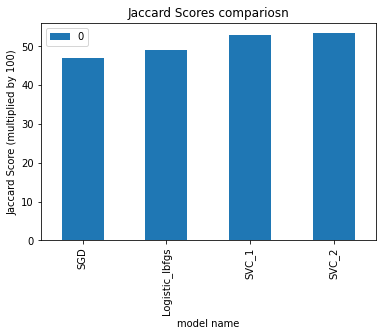

In [ ]:
plt.figure(figsize = (12,8))
plotdata = pd.DataFrame(JScores, index=model_names)
# Plot a bar chart
plotdata.plot(kind="bar")
plt.title("Jaccard Scores compariosn")
plt.xlabel('model name')
plt.ylabel('Jaccard Score (multiplied by 100)')
plt.show()

<Figure size 864x576 with 0 Axes>

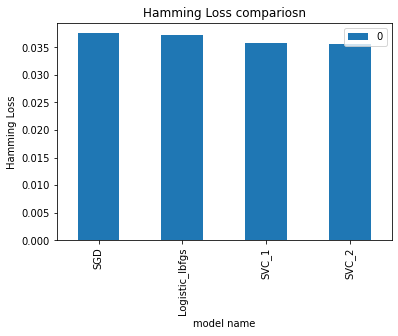

In [ ]:
plt.figure(figsize = (12,8))
plotdata = pd.DataFrame(Hamming_loss, index=model_names)
# Plot a bar chart
plotdata.plot(kind="bar")
plt.title("Hamming Loss compariosn")
plt.xlabel('model name')
plt.ylabel('Hamming Loss')
plt.show()